In [1]:
from IPython.display import HTML
from celluloid import Camera

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import pandas as pd

In [2]:
num_samples = 10000

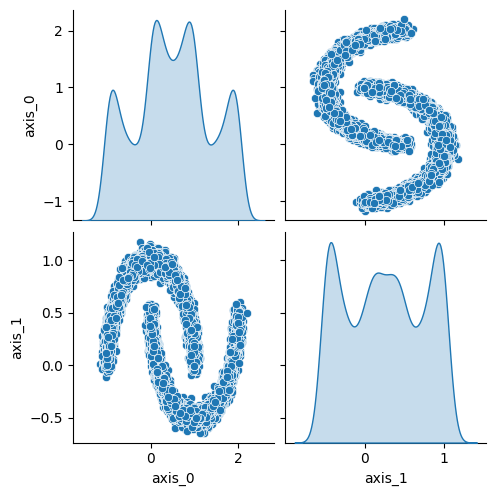

In [3]:
from sklearn import cluster, datasets
x, _ = datasets.make_moons(n_samples=num_samples, noise=0.05)
cols = ['axis_'+str(i) for i in range(x.shape[1])]
df = pd.DataFrame(x, columns = cols)
sns.pairplot(df, diag_kind = 'kde')
plt.show()

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.linear_1(x))
        z = F.leaky_relu(self.linear_2(x))
        return z

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = F.leaky_relu(self.linear_1(z))
        x = F.leaky_relu(self.linear_2(z))
        return x

class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, latent_dim=16):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim = input_dim, 
                               hidden_dim = hidden_dim, 
                               latent_dim = latent_dim)
        
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.variance_layer = nn.Linear(latent_dim, latent_dim)
        
        self.decoder = Decoder(output_dim = input_dim, 
                               hidden_dim = hidden_dim, 
                               latent_dim = latent_dim)

    def reparameterization(self, mean, var):
        # reparameterize is with standard deviation not variance. Hence the 1/2
        epsilon = torch.randn_like(torch.exp(1/2 * var))
        z = mean + var*epsilon
        return z
        
    def forward(self, x):
        z = self.encoder(x)
        mu, var = self.mean_layer(z), self.variance_layer(z)
        z = self.reparameterization(mu, var) 
        x_hat = self.decoder(z)  
        return x_hat, z,  mu, var

In [5]:
def loss_function(x, x_hat, z, mean, var):
    loss = F.mse_loss(x_hat, x, reduce = 'mean')
    
    # the kl_divergence has its own derivation but the basic idea is that it forces z to be normal distributed. 
    # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
    kl_divergence = torch.mean(-0.5 * torch.sum(1 + var - mean.pow(2) - var.exp(),dim=1),dim=0)
    return loss + kl_divergence

In [6]:
model = VAE()
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
batch_size = 128
epochs = 1000
num_batches = x.shape[0]//batch_size

In [8]:
for epoch in tqdm(range(epochs)):
    loss_batch = []
    for batch_num in range(num_batches):
        x_batch = x[batch_num*batch_size:(batch_num+1)*batch_size,:]       
        x_batch = torch.tensor(x_batch, dtype=torch.float32)
        optimizer.zero_grad()

        x_hat, z, mean, log_var = model(x_batch)
        loss = loss_function(x_batch, x_hat, z, mean, log_var)
    
        loss.backward()
        optimizer.step()
        
        loss_batch.append(loss.item())
    loss_batch = np.mean(loss_batch)
    if epoch%100 == 0:
        print(f"[{epoch}] Training Loss : {loss_batch}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/sohamdandapath/miniconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[0] Training Loss : 0.6734406031095065
[100] Training Loss : 0.0265034232288599
[200] Training Loss : 0.0024697796340124346
[300] Training Loss : 0.0015913746483886663
[400] Training Loss : 0.0007649266731161147
[500] Training Loss : 0.0007001887760662402
[600] Training Loss : 0.0007829346614949501
[700] Training Loss : 0.0005627002220791884
[800] Training Loss : 0.0004713969582763429
[900] Training Loss : 0.00038467444634685916


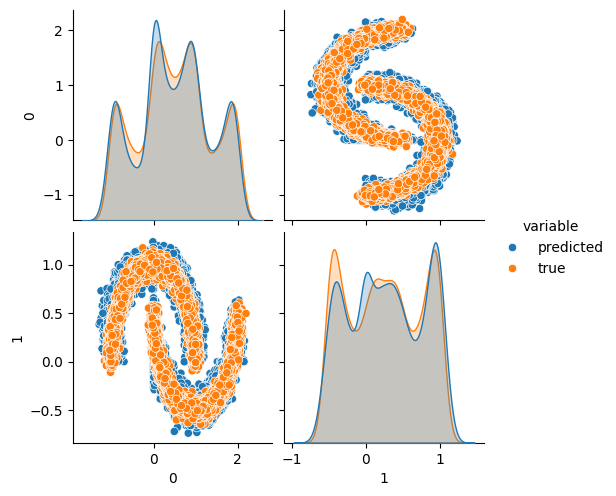

In [9]:
x_pred = []
with torch.no_grad():
    for batch_num in range(num_batches):
        x_batch = x[batch_num*batch_size:(batch_num+1)*batch_size,:]       
        x_batch = torch.tensor(x_batch, dtype=torch.float32)
    
        x_hat, z, mean, var = model(x_batch)
        x_pred.append(x_hat.detach().numpy())
x_pred = np.array(x_pred).reshape(-1,2)       

df1 = pd.DataFrame(x_pred)
df1['variable'] = 'predicted'
df2 = pd.DataFrame(x)
df2['variable'] = 'true'
df = pd.concat([df1, df2])
sns.pairplot(df, hue= 'variable', diag_kind = 'kde')